# Ensemble Learning

This chapter is based on contents from Geron, chapter 7, and Raschka, chapter 7.

Ensemble Learning refers to the combination of predictions by an ensemble of learners. We have previously encountered one important ensemble method, the Random Forest.

The general idea of ensemble learning is to exploit the "wisdom of the crowd", i.e., the fact that multiple weak predictors, i.e., predictors not performing very well, can be combined to one strong predictor achieving a better performance than any one of the individual predictors. The greatest advantage of ensemble learning over individual learners would be achieved if predictions of the latter were uncorrelated; more generally, the smaller the correlation between the learners, the larger the benefit of combining them to an ensemble.

Ensemble learning can be used for both classification and regression tasks. All methods of combining predictions can be used for classification tasks, while only some of them are suitable for regression tasks.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_hastie_10_2, make_moons
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

# Voting classifiers

The following figure shows three different situations in a classification task using an ensemble of 10 learners. If there is unanimity in the predictions of all learners, the prediction of the ensemble method is obvious and it does not perform better than the individual learners. In a binary classification task the __majority voting__ rule predicts the class that has been predicted by the majority of the learners contained in the ensemble. If there are more than two classes, the __plurality voting__ rule predicts the most frequent prediction, i.e., the mode. These voting rules using only the class predicted by each learner are called __hard voting__ classifiers. Voting rules that also make use of the probabilities predicted by each of the learners are called __soft voting__ classifiers.
<center>

<img src="images/07_01.png" align="center" width="800" />
</center>
(Raschka)

<center>

<img src="images/07_02.png" align="center" width="800" />
</center>
(Raschka)

`sklearn` offers the class `VotingClassifier` that applies a voting classifier to an ensemble of classifiers.

We demonstrate its application using an example based on one of the datasets available in sklearn.

In [2]:
X, y = make_hastie_10_2(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

We combine two decision tree classifiers, with different hyperparameters, and one logistic regression. We first apply the hard majority decision rule. We fit the `VotingClassifier` and each individual classifier.

In [3]:
dtc1_clf = DecisionTreeClassifier(max_depth=1, random_state=42)
dtc2_clf = DecisionTreeClassifier(max_depth=2, min_samples_leaf=3000, random_state=42)
log_clf = LogisticRegression(random_state=42, C=100)

voting_clf = VotingClassifier(
    estimators=[('d1', dtc1_clf), ('d2', dtc2_clf), ('log', log_clf)],
    voting='hard')

for clf in (dtc1_clf, dtc2_clf, log_clf, voting_clf):
    clf.fit(X_train, y_train)

We predict the classes for the test samples, and print the accuracy of each learner for the test data.

In [4]:
for clf in (dtc1_clf, dtc2_clf, log_clf, voting_clf):
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

DecisionTreeClassifier 0.537
DecisionTreeClassifier 0.5306666666666666
LogisticRegression 0.5023333333333333
VotingClassifier 0.5403333333333333


To apply the soft voting rule, we set the parameter `voting='soft'`.

In [5]:
voting_clf = VotingClassifier(
    estimators=[('d1', dtc1_clf), ('d2', dtc2_clf), ('log', log_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

for clf in (dtc1_clf, dtc2_clf, log_clf, voting_clf):
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

DecisionTreeClassifier 0.537
DecisionTreeClassifier 0.5306666666666666
LogisticRegression 0.5023333333333333
VotingClassifier 0.5586666666666666


It is possible to give different learners different weights via the parameter `weights`. This makes sense if we know that some of the learners perform better than others.

In [6]:
voting_clf = VotingClassifier(
    estimators=[('d1', dtc1_clf), ('d2', dtc2_clf), ('log', log_clf)],
    voting='soft', weights=[0.4,0.4,0.2])
voting_clf.fit(X_train, y_train)

for clf in (dtc1_clf, dtc2_clf, log_clf, voting_clf):
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

DecisionTreeClassifier 0.537
DecisionTreeClassifier 0.5306666666666666
LogisticRegression 0.5023333333333333
VotingClassifier 0.5616666666666666


# Bagging and pasting
Bagging, short for __bootstrap aggregating__, is an ensemble method using the same learning algorithm for different bootstrapped training sets, i.e., training sets drawn from the aggregate training data with replacement. __Pasting__ differs from bagging in that the data is sampled without replacement.
<center>

<img src="images/07_06.png" align="center" width="750" />
</center>
(Raschka)

Bagging and pasting are both implemented in scikit-learn's classes `BaggingClassifier` and `BaggingRegressor`. By default, an instance of the class is a bagging classifier. The size of each training set is equal to the size of the original training data unless we set `max_samples`.

In [7]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

The `BaggingClassifier` achieves a higher accuracy score than an individual `DecisionTreeClassifier`.

In [8]:
print(accuracy_score(y_test, y_pred))

0.904


In [9]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [10]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

The decision boundaries show that bagging avoids the problem of overfitting seen for the individual decision tree.

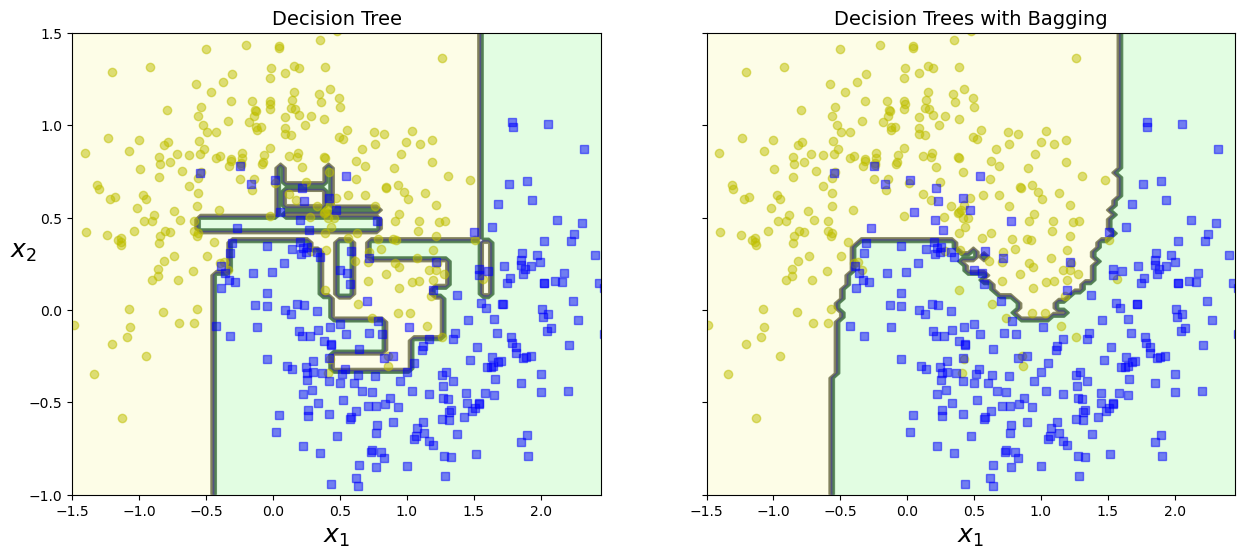

In [11]:
fix, axes = plt.subplots(ncols=2, figsize=(15,6), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

The pasting classifier is not implemented as a class of its own in scikit-learn. To create a pasting classifier, we can use the class `BaggingClassifier` and set the parameter `bootstrap=False`.

In [12]:
paste_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=False, random_state=42)
paste_clf.fit(X_train, y_train)
y_pred = paste_clf.predict(X_test)

In [13]:
print(accuracy_score(y_test, y_pred))

0.92


When applying bagging, only a subset of the whole training data set will be used by each classifier. We can use the remaining samples to evaluate their performance. This is called __out-of-bag (oob) evaluation__. This evaluation is conducted if we set the parameter `oob_score=True`. If we do so, the `BaggingClassifier` object will have the attributes `oob_score_` and `oob_decision_function_`. The former is the average oob accuracy, the latter the average oob prediction for each training sample, expressed as probabilities.

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [15]:
bag_clf.oob_decision_function_[0:10]

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637]])

## Random Patches and Random Subspaces

Instead of, or in addition to, random sampling of the training data, it is also possible to sample the features. In `sklearn`, this is done via the parameter `max_features`. If we only sample the features but use the whole training data (i.e., `bootstrap=False` and `max_samples=1.0`), the method is called __Random Subspaces__. If both the data and the features are randomly sampled, the method is called __Random Patches__.

# Boosting

The idea behind boosting is to train a sequence of otherwise identical learners, where each learner puts a higher weight on those samples poorly predicted by its predecessor so as to improve on the predictions especially for those samples.

The figure below illustrates this idea, where an increased size of a sample corresponds to an increased weight in the prediction.
<center>

<img src="images/07_09.png" align="center" width="500" />
</center>
(Raschka)

# AdaBoost

AdaBoost (short for Adaptive Boosting) is the most commonly used boosting algorithm. If $m$ is the number of predictors, the algorithm (for the case of a classification task; the adjustment to the weights slightly differs for AdaBoost regressors, where the magnitude of the prediction error matters) works as follows:

Initially the samples have uniform weights, with $\sum_i w^{(i)}=1$

For each learner $j$ repeat the following:
* train the learner using the current weights
* predict the target values $\hat{y}$
* compute the weighted error rate $\varepsilon=\mathbf{w}\cdot\mathbf{1}_{\hat{y}\neq\mathbf{y}}$
* compute the predictor weight $\alpha_j=\log\frac{1-\varepsilon}{\varepsilon}$
* update each weight to $w_{j+1}^{(i)}=w_j^{(i)}\exp\big(\alpha_j\mathbf{1}_{\hat{y}_j^{(i)}\neq y_j^{(i)}}\big)$
* Normalize weights to $\sum_i w^{(i)}=1$

The prediction is then done by a weighted majority vote:
$\hat{y}(\mathbf{x})=\text{argmax}_k\sum_{j=1}^m\alpha_j\mathbf{1}_{\hat{y}(\mathbf{x})=k}$

AdaBoost is available in `sklearn` via the classes `AdaBoostClassifier` and `AdaBoostRegressor`. We will illustrate the classifier using a data set containing different types of wine and their features.

In [16]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     random_state=1,
                                                     stratify=y)

We will use a `DecisionTreeClassifier` as the base `estimator` that we pass to the `AdaBoostClassifier`. If we do not specify the `estimator`, a `DecisionTreeClassifier(max_depth=1)` will be used.

In [17]:
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

We apply `fit` and `predict` to the base classifier and to the `AdaBoostClassifier` to compare their performance.

In [18]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 1.000/0.917


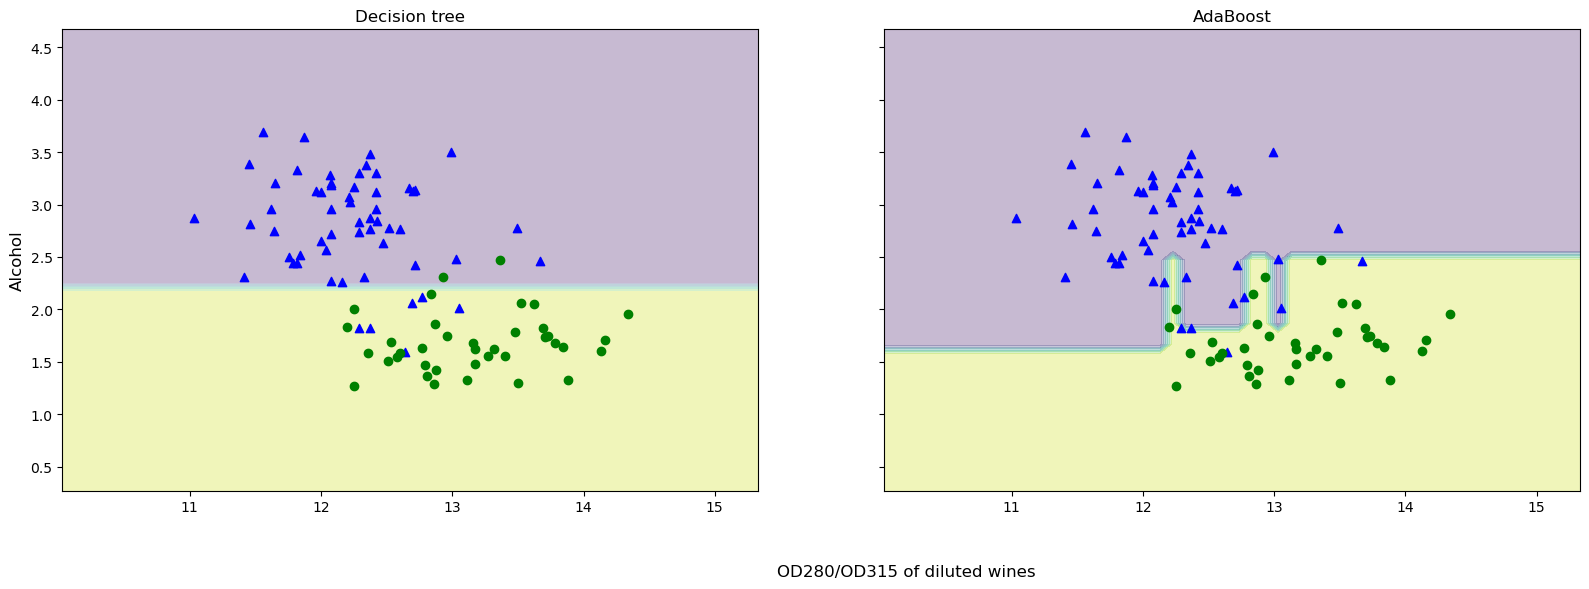

In [19]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16, 6))
for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

The figure shows the decision regions for the decision tree and for AdaBoost.

By default, the `AdaBoostClassifier` uses the predicted classes, not `predict_proba`, when computing the errors. The argument `algorithm="SAMME.R"` makes it use an algorithm employing `predict_proba`, which generally leads to better performance. Either way, `AdaBoostClassifier` can be used not only for binary, but also for multi-class classification tasks.

## Gradient Boosting

Instead of changing the weights with each learner while retaining the training data, Gradient Boosting uses the residual error of the previous learner as the training data for the next one. The ultimate prediction is then the sum of the predictions of the individual learners. The base estimator is usually a decision tree. The method is then called __Gradient Tree Boosting__, or, when applied to regression tasks, __Gradient Boosted Regression Trees (GBRT)__.

We will first take a look at a manual implementation of GBRT to demontrate how the method works.

After creating some random data, we apply a `DecisionTreeRegressor` to the data.

In [20]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [21]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

We then take the prediction errors and train another `DecisionTreeRegressor` on them.

In [22]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

We repeat the procedure another time.

In [23]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

The prediction of GBRT is then the sum of the individual predictions.

In [24]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [25]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

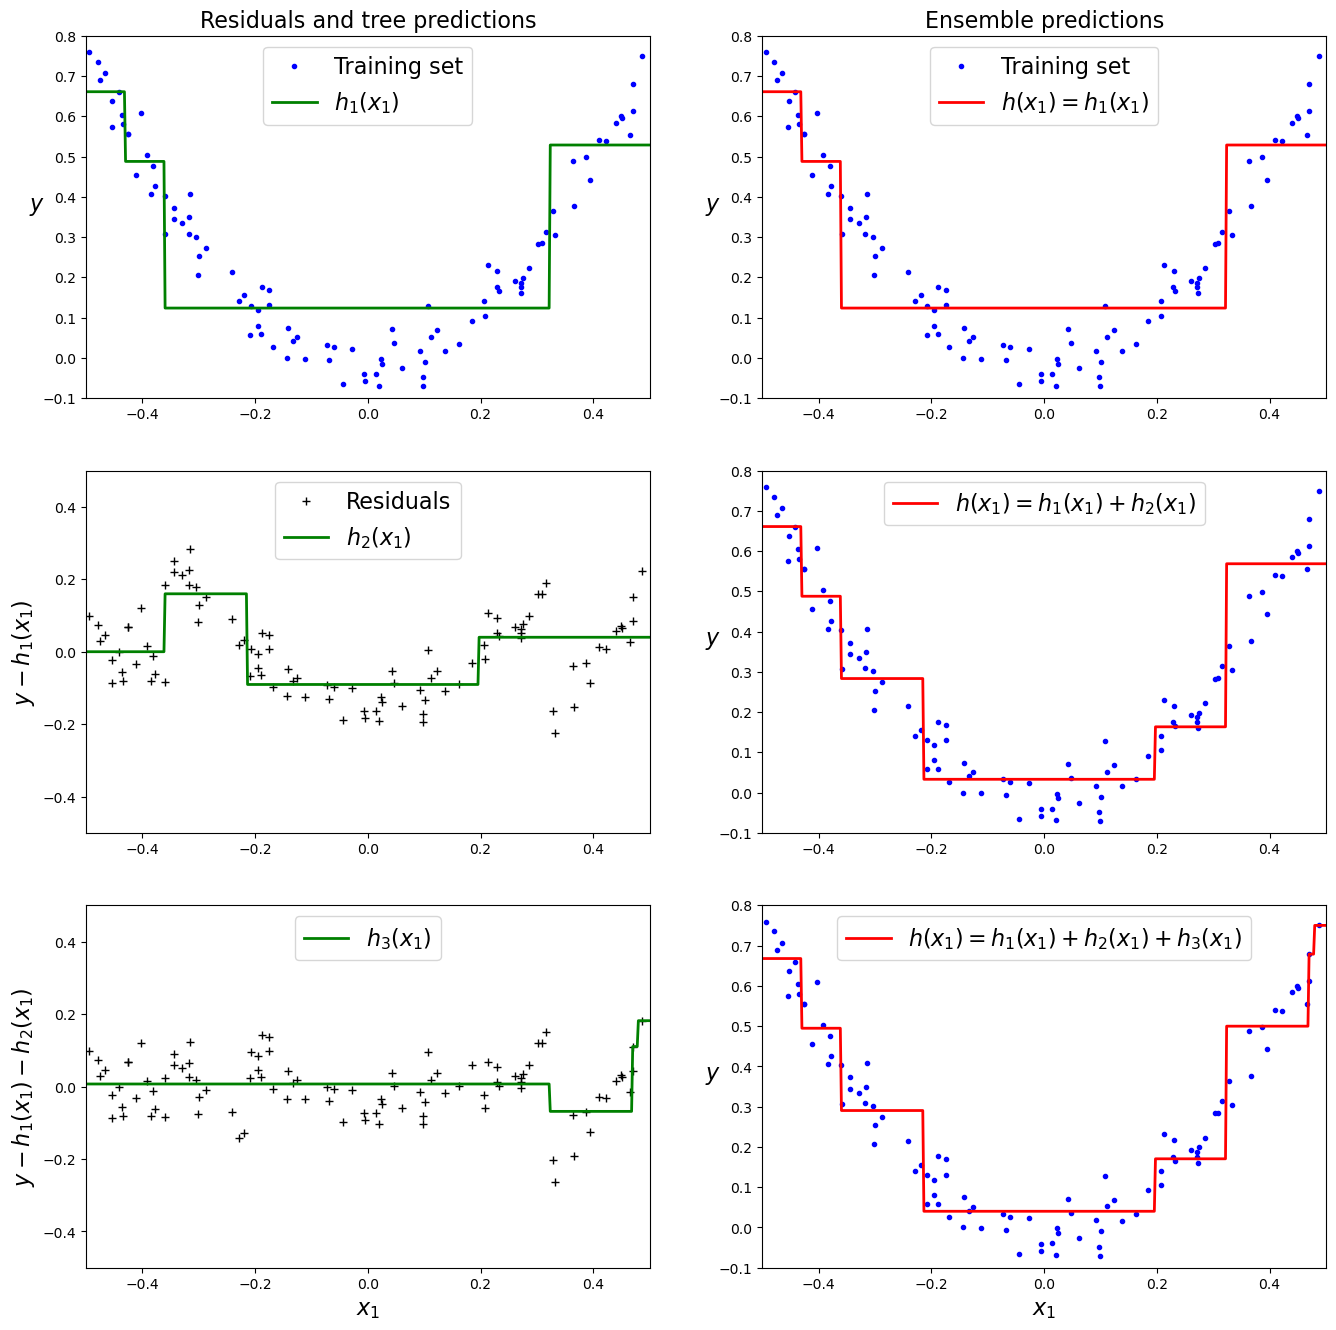

In [26]:
plt.figure(figsize=(16,16))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.show()

The figures above show the predictions of the individal trees on the left and the cumulative sums of the predictions on the right.

GBRT is implemented in scikit-learn's class `GradientBoostingRegressor`. The argument `learning_rate` determines the contribution of each tree to the prediction. A high learning rate can lead to overfitting, though a low learning rate means that more trees are needed to get a good predictive performance. Using too many trees, specified by the argument `n_estimators`, also tends to increase the overfitting of the training data. The parameters of the individual trees can be used to adjust the tradeoff between bias and variance, too.

Below, there are two examples of GBRT for different hyperparameters, one underfitting and another overfitting the data.

In [27]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [28]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

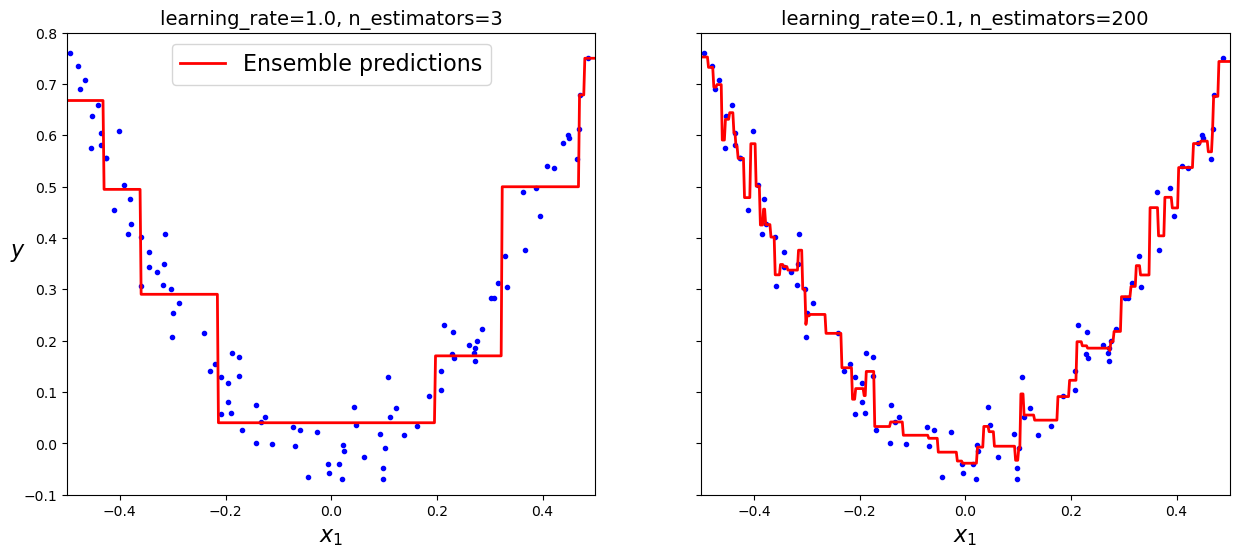

In [29]:
fix, axes = plt.subplots(ncols=2, figsize=(15,6), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

## Gradient Boosting with Early stopping

If we are concerned with overfitting, we can apply early stopping when the performance on the validation data is optimized. The class `GradientBoostingRegressor` offers the method `staged_predict` that returns a generator of the predictions at each stage, i.e., if only the first $k$ trees are used. Thus, based on the performance of the staged predictions, we can select the optimal `n_estimators`.

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1
min_error = np.min(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

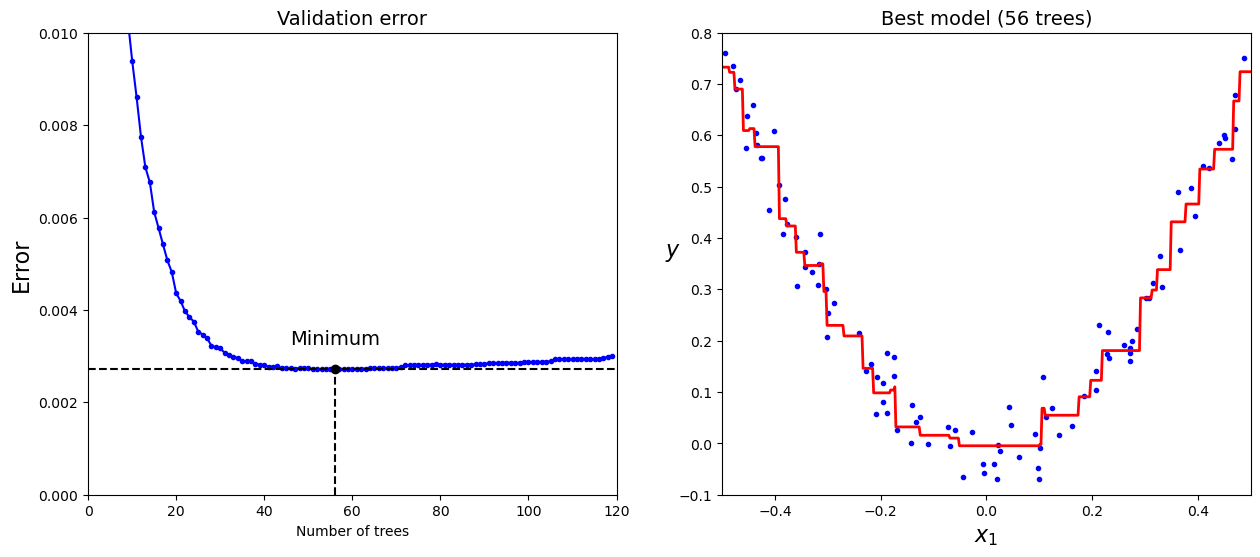

In [31]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)
plt.show()